In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

In [2]:
marker_path = './mocap_data/V48_01_SOMA/marker_dataset/train/markers.pt'

marker_data = torch.load(marker_path)

marker_data.shape

torch.Size([1043609, 1, 159])

In [3]:
marker_data = marker_data.reshape(-1, 1, 159 // 3, 3)
marker_data.shape

torch.Size([1043609, 1, 53, 3])

In [4]:
marker_data = marker_data[:, 0, :, :]
marker_data.shape

torch.Size([1043609, 53, 3])

In [7]:
noise_path = './mocap_data/V48_01_SOMA/amass_marker_noise/train/amass_marker_noise_model.npz'
noise_data = np.load(noise_path)

# 打印数组名称和内容
print(noise_data.files)  
print(noise_data['amass_marker_noise_model'].shape)

['amass_marker_noise_model']
(87463, 1, 53, 3)


In [8]:
noise_data = torch.from_numpy(noise_data['amass_marker_noise_model'])
noise_data = noise_data[:, 0, :, :]
noise_data.shape

torch.Size([87463, 53, 3])

In [10]:
num_frames_to_replace = 20  # 替换的帧数
num_markers_to_replace = 5  # 每帧替换的marker数

In [12]:
# 随机选择要替换的帧索引
marker_frame_indices = np.random.choice(marker_data.shape[0], num_frames_to_replace, replace=False)
noise_frame_indices = np.random.choice(noise_data.shape[0], num_frames_to_replace, replace=False)

noised_data = marker_data
# 替换marker_data中的部分marker坐标
for i in range(num_frames_to_replace):
# 随机选择要替换的marker索引
    marker_indices = np.random.choice(marker_data.shape[1], num_markers_to_replace, replace=False)
    for marker_idx in marker_indices:
        noised_data[marker_frame_indices[i], marker_idx, :] = noise_data[noise_frame_indices[i], marker_idx, :]

noised_data.shape

torch.Size([1043609, 53, 3])

In [19]:
# 生成不同setting的marker数据

In [20]:
from smplx import SMPL
import torch

# 加载SMPL模型
smpl_model_path = './body_models/smpl/'  # 替换为你的SMPL模型路径
smpl = SMPL(model_path=smpl_model_path, gender='neutral')

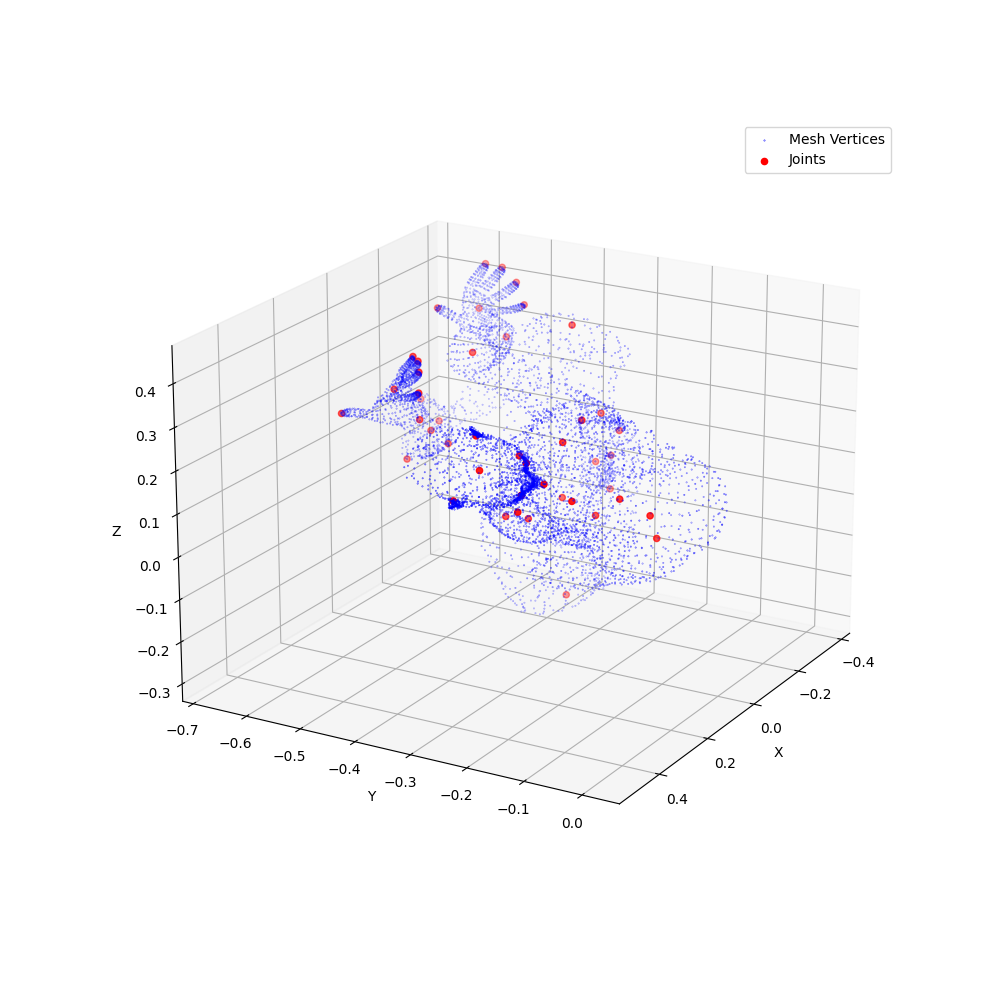

In [23]:
# 提取pose数据
pose_sample = torch.randn(1, 69)  # 转换为 (1, 69)

# SMPL模型需要的输入
global_orient = torch.zeros(1, 3)  # 全局旋转
body_pose = pose_sample  # 身体姿态
betas = torch.zeros(1, 10)  # 身体形状参数

# 使用SMPL模型生成3D网格和关节
output = smpl(global_orient=global_orient, body_pose=body_pose, betas=betas)
vertices = output.vertices.detach().numpy().squeeze()  # (6890, 3)
joints = output.joints.detach().numpy().squeeze()  # (49, 3)

# 可视化3D网格和关节
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制网格顶点
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], s=0.1, color='blue', label='Mesh Vertices')

# 绘制关节
ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], s=20, color='red', label='Joints')

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置视角
ax.view_init(elev=20, azim=30)

# 添加图例
ax.legend()

# 显示图形
plt.show()

In [24]:
# 随机采样固定的点
num_sample_points = 100  # 采样点的数量
num_vertices = smpl.get_num_verts()  # SMPL模型的顶点数量
sampled_indices = np.random.choice(num_vertices, num_sample_points, replace=False)  # 随机选择顶点索引

# 输入的pose
# pose_sample = pose_data[100000][0].reshape(1, -1)  # 转换为 (1, 63)
global_orient = torch.zeros(1, 3)  # 全局旋转
betas = torch.zeros(1, 10)  # 身体形状参数

# 使用SMPL模型生成3D网格
output = smpl(global_orient=global_orient, body_pose=pose_sample, betas=betas)
vertices = output.vertices.detach().numpy().squeeze()  # (6890, 3)

# 提取采样点的空间坐标
sampled_points = vertices[sampled_indices]

# 输出采样点的空间坐标
print("Sampled Points Coordinates:")
print(sampled_points)

Sampled Points Coordinates:
[[ 0.12032708 -0.560937    0.25308302]
 [-0.05409781 -0.25506866  0.26219285]
 [ 0.2462601  -0.04997145  0.10322481]
 [ 0.11002526 -0.17840113 -0.01704794]
 [ 0.11981662 -0.5352594   0.2705656 ]
 [-0.26636904 -0.2673307   0.11780983]
 [ 0.2810654  -0.26810712  0.18607658]
 [-0.09271271 -0.27939194  0.07956326]
 [-0.22953185 -0.62137234  0.34765926]
 [ 0.29676136 -0.2836274   0.26478827]
 [ 0.33938065 -0.24012104  0.16907144]
 [ 0.20696327 -0.21248968  0.10800225]
 [ 0.33425096 -0.25338155  0.16475353]
 [ 0.33105028 -0.18056136  0.2023775 ]
 [-0.27976882 -0.3683049   0.00539121]
 [ 0.3088904  -0.18467215  0.23160982]
 [-0.3288078  -0.53557533  0.33222356]
 [ 0.19819596 -0.1245083   0.03351438]
 [-0.06522092 -0.30375603 -0.04949757]
 [ 0.20186666 -0.28537378  0.23392929]
 [-0.09756321 -0.30046296 -0.1006822 ]
 [-0.27041954 -0.36155415 -0.17610031]
 [ 0.29004204 -0.26341945  0.17389503]
 [-0.04784047 -0.3506527   0.242566  ]
 [ 0.2061642  -0.18441018  0.0506661

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# 提取坐标
x_coords = sampled_points[:, 0]
y_coords = sampled_points[:, 1]
z_coords = sampled_points[:, 2]

# 创建3D图形
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Sampled Points')

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 添加图例
ax.legend()

# 设置视角
ax.view_init(elev=20, azim=30)

# 显示图形
plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam

# 定义Transformer模型
class MarkerToPoseTransformer(nn.Module):
    def __init__(self, marker_dim, pose_dim, num_heads, num_layers, hidden_dim):
        super(MarkerToPoseTransformer, self).__init__()
        self.input_proj = nn.Linear(marker_dim, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers
        )
        self.output_proj = nn.Linear(hidden_dim, pose_dim)

    def forward(self, markers):
        # 假设markers的形状为 (batch_size, seq_len, marker_dim)
        markers = self.input_proj(markers)  # 投影到hidden_dim
        markers = markers.permute(1, 0, 2)  # 转换为 (seq_len, batch_size, hidden_dim)
        output = self.transformer(markers, markers)  # Transformer的输入和输出
        output = output.permute(1, 0, 2)  # 转换回 (batch_size, seq_len, hidden_dim)
        pose = self.output_proj(output)  # 投影到pose_dim
        return pose

# 定义超参数
marker_dim = marker_data.shape[-1]  # marker的维度
pose_dim = pose_data.shape[-1]  # pose的维度
num_heads = 4
num_layers = 2
hidden_dim = 128
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

# 创建模型、损失函数和优化器
model = MarkerToPoseTransformer(marker_dim, pose_dim, num_heads, num_layers, hidden_dim)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# 创建DataLoader
train_loader = DataLoader(marker_dataset, batch_size=batch_size, shuffle=True)

# 训练循环
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        # 假设batch的形状为 (batch_size, seq_len, marker_dim)
        optimizer.zero_grad()
        predicted_pose = model(batch)  # 预测pose
        target_pose = pose_data[:batch.shape[0]]  # 获取对应的pose
        loss = criterion(predicted_pose, target_pose)  # 计算损失
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
class MarkerVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128):
        super(MarkerVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.encoder_fc1(x))
        mean = self.encoder_fc2_mean(h)
        logvar = self.encoder_fc2_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h = F.relu(self.decoder_fc1(z))
        x_reconstructed = torch.sigmoid(self.decoder_fc2(h))
        return x_reconstructed

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mean, logvar

# 定义超参数
input_dim = marker_data.shape[-1] * marker_data.shape[-2]  # marker 数据的展平维度
latent_dim = 64  # 潜在空间维度
hidden_dim = 128  # 隐藏层维度

# 创建模型实例
marker_vae = MarkerVAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim)

# 打印模型结构
print(marker_vae)